##  PyTorch实现一维卷积神经网络（CNN）

和LSTM一样，以2015年中山公园站每15min客流的进站数据为例，利用PyTorch搭建一维卷积神经网络，实现对进站客流数据的预测。

（1）数据集的导入和处理

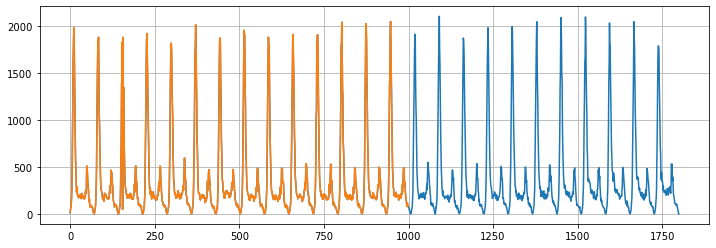

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 导入前述LSTM15min进站客流
data_csv = pd.read_csv('./zhongshanpark.csv', encoding = 'gb2312')
data_csv.head()  # 观察数据集，这是一个单变量时间序列

y = data_csv["中山公园"].values.astype(float)  # 数据类型改为浮点型
plt.figure(figsize=(12, 4))
plt.grid(True)  # 网格化处理
plt.plot(y)
plt.plot(data_csv[0:1000]) #查看前1000个序列

输入中山公园地铁站进站客流数据后，需要划分训练集和测试集。共有1800个时间段的客流数据，以数据集的后500个作为测试集。为了获得更好的训练效果，将客流数据进行归一化处理，归一化到[-1,1]区间。具体代码如下：

In [6]:
# 划分测试集和训练集，最后500个作为测试集
test_size = 500
train_iter = y[:-test_size]
test_iter = y[-test_size:]
# 归一化至[-1,1]区间，为了获得更好的训练效果
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_iter.reshape(-1, 1))

# 创建时间序列训练集
train_set = torch.FloatTensor(train_norm).view(-1)



为了更好了解网络预测的准确性，笔者设定时间窗口来选取数据进行预测，时间窗口的大小为72，即从原时间序列中抽取出训练样本，用第一个到第七十二个数据作为x输入，预测第七十三个值作为y输出。这是一个用于训练的数据点，时间窗口向后滑动不断进行训练。此处定义了函数input_data进行训练样本抽取，并且返回由输入数据和输出标签构成的列表。代码如下：

In [7]:
# 定义时间窗口
Time_window_size = 72

# 从原时间序列中抽取出训练样本，用第1个值到第72个值作为X输入，预测第73个值作为y输出，这是一个用于训练的数据点，时间窗口向后滑动以此类推
def input_data(seq, ws):  
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i + ws]
        label = seq[i + ws:i + ws + 1]
        out.append((window, label))
    return out


train_data = input_data(train_set, Time_window_size)
len(train_data)  # 等于1800（原始数据集长度）-500（测试集长度）-72（时间窗口）


1228

最新版本1.23.0的numpy中提供了一个sliding_window_view函数，该函数通过输入时间序列以及时间窗大小，可自动实现训练样本的提取，使用方式如下：

In [8]:
from numpy.lib.stride_tricks import sliding_window_view
output = sliding_window_view(train_set, Time_window_size)
len(output)

1229

为提高预测的精确度，该一维卷积神经网络采取了两层卷积层、一层最大池化层以及两层全连接层堆叠而成，使用ReLU作为激活函数，在池化作用后还使用dropout函数避免训练出现过拟合现象。另外本次实验采用GPU运算，提高计算效率。具体代码实现如下：


In [9]:
class CNNnetwork(nn.Module):
    def __init__(self):
        super(CNNnetwork, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(32*35, 640)
        self.fc2 = nn.Linear(640, 1)
        # self.fc1 = nn.Linear(32*70, 640)
        self.drop = nn.Dropout(0.5)
        
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
# device = torch.device("cuda")    #也可以用GPU计算提高效率
net = CNNnetwork()


接着就是定义损失函数和优化器。本实验选择MSELoss作为训练的损失函数，选择Adam作为训练的优化器，学习率lr=0.0005。代码如下：

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr= 0.0005)

接下来需要对网络进行训练。首先定义迭代次数epoch = 20，同时将网络调整为训练模式。接着利用for循环遍历训练所用的样本数据，需要注意的是在每次更新参数前需要进行梯度归零和初始化。由于输入的数据形状不符合网络输入的格式，还需要对样本数据的形状进行调整，调整为conv1的input_size: (batch_size, in_channels, series_legth)。


In [11]:
# 开始训练模型
epochs = 20
net.train()

for epoch in range(epochs):

    for seq, y_train in train_data:
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()
        y_train = y_train
        # 对样本进行reshape，换成conv1d的input size（batch_size, channel, series_legth)
        seq = seq.reshape(1, 1, -1)
        y_pred = net(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch + 1:2} Loss:{loss.item():10.8f}')
    #用CPU方法训练速度很慢，但是运用GPU“cuda”将会加快很多

Epoch:  1 Loss:0.06248763
Epoch:  2 Loss:0.00353675
Epoch:  3 Loss:0.00140748
Epoch:  4 Loss:0.02200599
Epoch:  5 Loss:0.01337492
Epoch:  6 Loss:0.02061914
Epoch:  7 Loss:0.02894808
Epoch:  8 Loss:0.03017926
Epoch:  9 Loss:0.00005710
Epoch: 10 Loss:0.01185677
Epoch: 11 Loss:0.00252814
Epoch: 12 Loss:0.00856474
Epoch: 13 Loss:0.00240003
Epoch: 14 Loss:0.00044753
Epoch: 15 Loss:0.00185589
Epoch: 16 Loss:0.00872996
Epoch: 17 Loss:0.00319078
Epoch: 18 Loss:0.01922969
Epoch: 19 Loss:0.01943579
Epoch: 20 Loss:0.00048056


模型训练完成以后，选取序列最后的72个数据开始预测。首先将网络模式设为eval模式，由于需要预测数据集的后500个数据，因此需要遍历500次，循环的每一步表示时间窗口向时间序列向后滑动一格，这样每一次最近时刻的真实值都会加入数据集作输入去预测输出新的客流数据，最新加入到时间窗口的值为真实值，而非预测值，可以一定程度上避免误差累积。同时因为是使用训练好的模型进行预测，因此不需要再对模型的权重和偏差进行反向传播和优化。另外在预测完成以后，为了体现预测的效果，将预测值进行逆归一化操作还原为真实的客流值，便于与实际客流进行比较。


In [12]:
future = 500

# 选取序列最后12个值开始预测
preds = train_set[-Time_window_size:].tolist()

# 设置成eval模式
net.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-Time_window_size:])
    with torch.no_grad():
        seq = seq.reshape(1,1,-1)
        preds.append(net(seq).item())
# 逆归一化还原真实值
true_predictions = scaler.inverse_transform(np.array(preds[Time_window_size:]).reshape(-1,1))

为了体现预测精度，对预测结果进行可视化，利用matplotlib.pyplot绘制预测结果和真实值的曲线图，比较二者数据的差异，得出网络训练的效果。最终得到的预测值和真实值的曲线图如图所示。

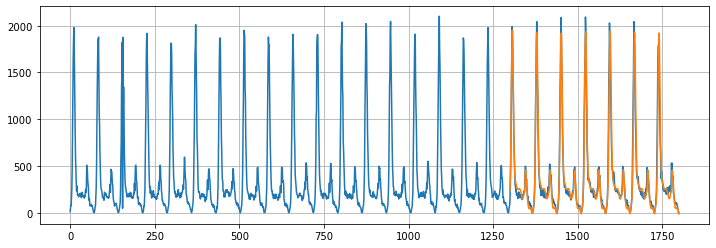

In [13]:
# 对比真实和预测值
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(y)
x = np.arange(1300, 1800)
plt.plot(x,true_predictions)
plt.show()


以上就是利用Pytorch实现基于一维卷积神经网络的时间序列预测的全过程，可以看到预测结果良好。由于PyTorch已经将所有的函数过程进行封装，因此网络搭建时可以直接调用，使用起来非常方便。同时还可以改变输入输出的维度，对其他时间序列数据集进行预测，这里就不再继续尝试。